###  Feature Selection (Important Genes)

In [1]:
# load result from Data Preprocessing
library(reshape2)
library(ggplot2)
library(ggcorrplot)
load("../transformed data/golub3051.rda")
set.seed(201703)

_**(a)**_. Neighbourhood analysis, permutation test and "signal-to-noise" ratio calculation: <span style="font-size: 0.8em;">$P(g, c) = (\mu_{AML}-\mu_{ALL})/(\sigma_{AML} + \sigma_{ALL})$ </span> as in notes 16 and 17. As we can see from the table at the end, neighbourhood analysis further reduce the number of predictors to 740 using 0.01 significant level permutation test.

In [2]:
# Neighbourhood analysis
##signal-to-noise ratio/PS in the paper
get_p = function(train_d, train_r){
    tr_m_aml =  colMeans(train_d[train_r == "AML",])
    tr_sd_aml = apply(train_d[train_r == "AML",], 2, sd)
    tr_m_all = colMeans(train_d[train_r == "ALL",])
    tr_sd_all = apply(train_d[train_r == "ALL",], 2, sd)
    p = (tr_m_aml-tr_m_all)/(tr_sd_aml+tr_sd_all)
    return(p)
}

In [3]:
nna = matrix(0, 400, 3051)
set.seed(201702)
# Permutation test
for(i in 1:400){
    t_r = sample(golub_train_response)
    nna[i, ] = get_p(golub_train_3051, t_r)
}

In [4]:
# Predictor selection based on the result of Neighbourhood analysis
nna_q = apply(nna, 2, quantile, prob = c(0.005, 0.995))
p = get_p(golub_train_3051, golub_train_response)
# With 0.01 significant level
index_1 = (1:3051)[p>=nna_q[2,] | p<=nna_q[1,]]
golub_train_p_trans = golub_train_3051[, index_1]
train_m_aml = colMeans(golub_train_p_trans[golub_train_response == "AML",])
train_m_all = colMeans(golub_train_p_trans[golub_train_response =="ALL",])
golub_test_p_trans =golub_test_3051[, index_1]
p = p[index_1]

In [5]:
cbind(train = dim(golub_train_p_trans),test = dim(golub_test_p_trans))

train,test
38,34
740,740


_**(b)**_. Select the informative 50 genes as in the original paper. We follow the note 18 in selecting the genes.

In [6]:
cl_index = c(head(order(p), 25), head(order(p, decreasing = T), 25))
p_50 = p[cl_index]
b = (train_m_aml[cl_index]+train_m_all[cl_index])/2
train_cl = golub_train_p_trans[, cl_index]
test_cl = golub_test_p_trans[, cl_index]
golub_train_50 = train_cl
golub_test_50 = test_cl
save(golub_train_50, golub_train_response, golub_test_50, golub_test_response,b,p_50, file = "../transformed data/golub50gene.rda")

_**(c)**_. Correlation Heatmap.

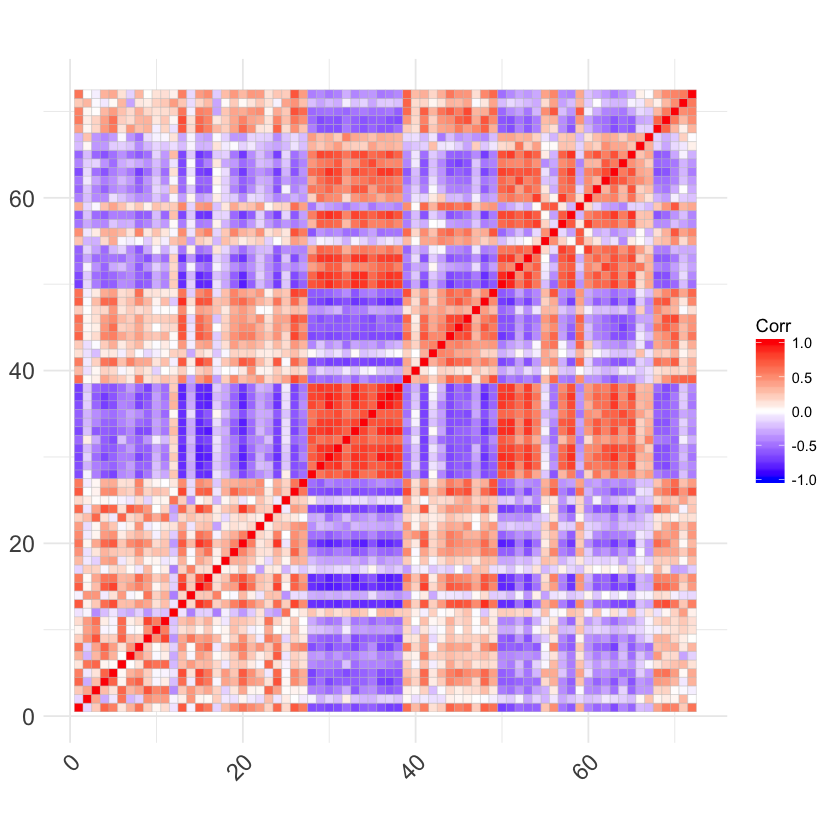

In [7]:
melt_data = rbind(golub_train_50, golub_test_50)
df_name = c(as.character(golub_train_response), as.character(golub_test_response))
df_id = order(df_name)
melt_data = data.frame(melt_data)
data_corr = cor(t(melt_data[df_id, ]))
ggcorrplot(data_corr,sig.level=0.05, lab_size = 4.5, p.mat = NULL, 
           insig = c("pch", "blank"), pch = 1, pch.col = "black", pch.cex =1,
           tl.cex = 14)